In [1]:
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch.nn as nn
from torch.autograd import Variable
import torch

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

In [2]:
transform = transforms.Compose(
            [
            # 左右対称の画像を生成してデータ量を増やす(Augmentation)
            # transforms.RandomHorizontalFlip(),

            # 256*256に画像サイズを変更
            transforms.Resize((256, 256)),

            # PyTorchで利用するTensorの形式にデータを変換
             transforms.ToTensor(),

            ])

train_data = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
val_data = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
test_data = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)

data_size  = {"train":len(train_data), "validation":len(val_data)}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

In [3]:
model = models.resnet18(pretrained=True)
print(model)

# ネットワークの重みを固定
for parameter in model.parameters():
    parameter.requires_grad = False

# 最終的な出力を2個に設定
model.fc = nn.Linear(512, 2)

if torch.cuda.is_available():
    model.cuda()


/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 下を別の方法で見る

In [4]:
def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_val=False):
  print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("VAL  " if is_val else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')

def cal_acc(output,label):
  p_arg = torch.argmax(output,dim = 1)
  return torch.sum(label == p_arg)

def Train_Eval(model,criterion,optimizer,data_loader,device,epoch,max_epoch,is_val = False):
  total_loss = 0.0
  total_acc = 0.0
  counter = 0
  model.eval() if is_val else model.train()
  for n,(data,label) in enumerate(data_loader):
    counter += data.shape[0]
    optimizer.zero_grad()
    data = data.to(device)
    label = label.to(device)
    if is_val:
      with torch.no_grad():
        output = model(data)
    else:
      output = model(data)
    loss = criterion(output,label)
    total_loss += loss.item()
    total_acc += cal_acc(output,label)
    
    if is_val != True:
      loss.backward()
      optimizer.step()
    show_score(epoch+1,max_epoch,n+1,len(data_loader),total_loss/(n+1) , total_acc/counter,is_val=is_val)
  print()
  return total_loss , total_acc

In [5]:
lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_loss = None

for epoch in range(EPOCHS):
  train_loss,train_acc = Train_Eval(model,criterion,optimizer,train_loader,DEVICE,epoch,EPOCHS) 
  val_loss,val_acc    = Train_Eval(model,criterion,optimizer,val_loader,DEVICE,epoch,EPOCHS,is_val=True)

  ## best_lossより小さなval_lossが出力された場合のみモデルを保存する。##
  if best_loss is None or val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), './best_ckpt1.pth')
  #################################################################
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)


TRAIN EPOCH[001/100] ITR [0562/0562] LOSS:0.48592 ACC:78.775055
VAL   EPOCH[001/100] ITR [0091/0091] LOSS:0.37783 ACC:86.049728
TRAIN EPOCH[002/100] ITR [0562/0562] LOSS:0.38429 ACC:84.532295
VAL   EPOCH[002/100] ITR [0091/0091] LOSS:0.32925 ACC:86.809395
TRAIN EPOCH[003/100] ITR [0562/0562] LOSS:0.35276 ACC:85.668152
VAL   EPOCH[003/100] ITR [0091/0091] LOSS:0.31381 ACC:87.361885
TRAIN EPOCH[004/100] ITR [0562/0562] LOSS:0.34318 ACC:85.890869
VAL   EPOCH[004/100] ITR [0091/0091] LOSS:0.31525 ACC:85.842545
TRAIN EPOCH[005/100] ITR [0562/0562] LOSS:0.33376 ACC:86.269485
VAL   EPOCH[005/100] ITR [0091/0091] LOSS:0.30831 ACC:86.602211
TRAIN EPOCH[006/100] ITR [0562/0562] LOSS:0.31938 ACC:87.015594
VAL   EPOCH[006/100] ITR [0091/0091] LOSS:0.29667 ACC:88.328728
TRAIN EPOCH[007/100] ITR [0562/0562] LOSS:0.31412 ACC:87.661469
VAL   EPOCH[007/100] ITR [0091/0091] LOSS:0.29725 ACC:88.190613
TRAIN EPOCH[008/100] ITR [0562/0562] LOSS:0.31381 ACC:87.4721600
VAL   EPOCH[008/100] ITR [0091/0091] LO

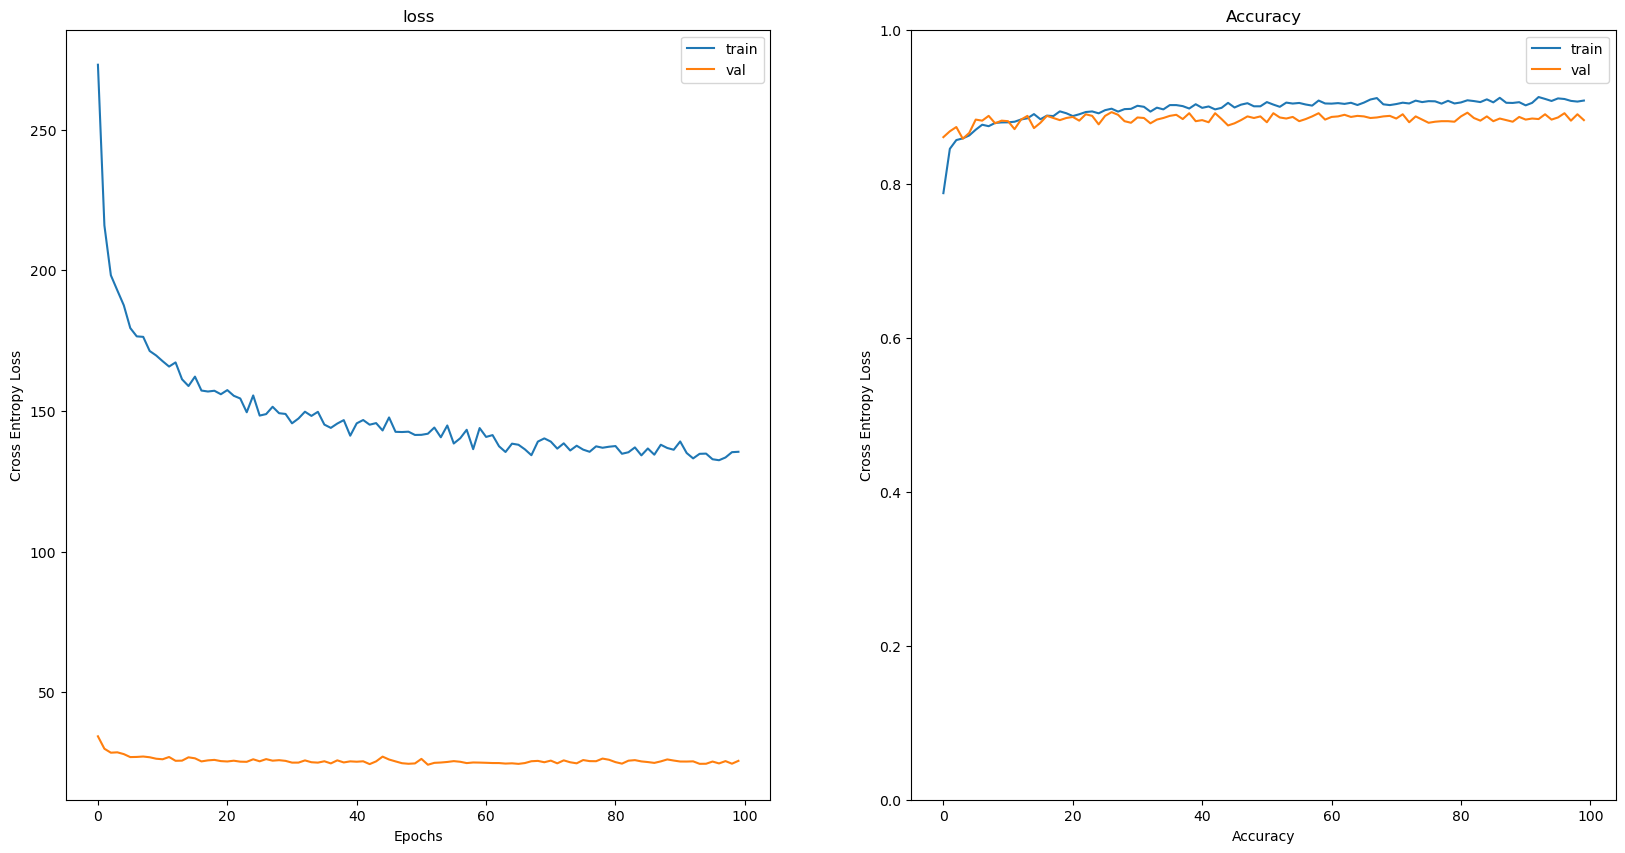

In [6]:
from matplotlib import pyplot as plt
from random import randint, random

## 描画データの準備
x = list(range(EPOCHS))
val_len = len(val_data)
train_len = len(train_data)
y1 = train_loss_list
y2 = val_loss_list

tensor_y3 = [x/train_len for x in train_acc_list]
tensor_y4 = [x/val_len for x in val_acc_list]

y3 = []
y4 = []

for acc in tensor_y3:
    acc = acc.to('cpu').detach().numpy().copy()
    y3.append(acc)

for acc in tensor_y4:
    acc = acc.to('cpu').detach().numpy().copy()
    y4.append(acc)


## 損失のグラフ描画
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 2, 1)

## グラフのラベル・タイトルを設定
ax.set_title("loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

## グラフをプロット
ax.plot(x, y1,label="train")
ax.plot(x, y2,label="val")

##凡例を描画
ax.legend()

## 精度のグラフ描画
ax = fig.add_subplot(1, 2, 2)
## グラフのラベル・タイトルを設定
plt.ylim([0,1])
ax.set_title("Accuracy")
ax.set_xlabel('Accuracy')
ax.set_ylabel('Cross Entropy Loss')

## グラフをプロット
ax.plot(x, y3,label="train")
ax.plot(x, y4,label="val")

##凡例を描画
ax.legend()

plt.show()

In [7]:
model.load_state_dict(torch.load('./best_ckpt1.pth'))

def test_model(model, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    current_loss = 0.0
    current_corrects = 0

    for data in test_loader:
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)

        current_loss += loss.item() * inputs.size(0) 
        current_corrects += torch.sum(preds == labels)

    epoch_loss = current_loss / len(test_data)

    epoch_acc = current_corrects.item() / len(test_data)

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return model

test_model = test_model(model, criterion)

Loss: 0.2713 Acc: 0.8942
